In [73]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.constants import e, epsilon_0 
from scipy.constants import physical_constants as pc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

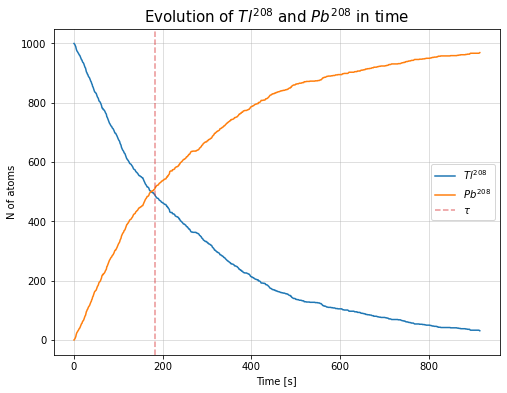

In [74]:
tau_TlPb = 3.052*60

# probability of decay
def p(time, tau):
    return 1-2**(-time/tau)

Tl_atoms = np.array([1000])
# Pb_atoms = [0]

t0 = 0
tf = 5*tau_TlPb

t = np.arange(t0, tf, 1)
x = np.random.random(1000) # sample 1000 random numbers between 0 and 1 from a uniform distribution

# at each time-step decide whether each Tl atom has decayed or not 
# if xi < p(t) then the i-th atom decayed
for time in t[1:]:
    Tl_atoms = np.append(Tl_atoms, Tl_atoms[0]-np.sum([x<p(time, tau_TlPb)]))

Pb_atoms = 1000-Tl_atoms

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, Tl_atoms, label = r'$Tl^{208}$')
ax.plot(t, Pb_atoms, label = r'$Pb^{208}$')
ax.grid(alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('N of atoms')
ax.set_title(r'Evolution of $Tl^{208}$ and $Pb^{208}$ in time', fontsize=15)
ax.axvline(tau_TlPb, color='C3', linestyle='--', alpha=0.5, label=r'$\tau$')
ax.legend();
    

_Second point_

Given the non-uniform probability distribution 
$$
p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}
$$
I can find analitically the ICDF.

$$
\int_{0}^{t(z)} p(t') dt' = \frac{\ln 2}{\tau}\int_{0}^{t(z)} 2^{-t/\tau}dt' = \frac{\ln 2}{\tau} \left[-\frac{\tau}{\ln 2}\right]\left.2^{-t/\tau}\right\vert_{0}^{t(z)} = -2^{-t(z)/\tau}+1 = z
$$

and thus:

$$
t(z) = - \tau\log_2{(1-z)}
$$

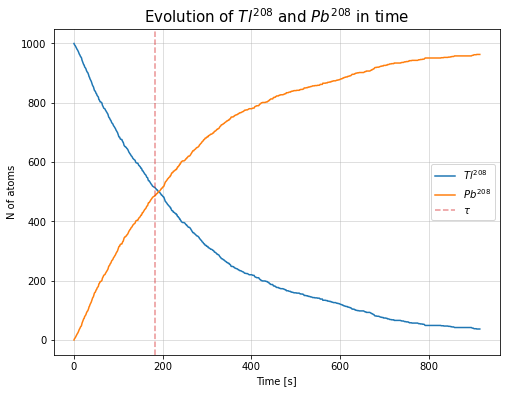

In [75]:
# define the ICDF
def icdf(z, tau=tau_TlPb):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -tau*np.log2(1-z)

# draw 1000 numbers from the non-uniform pdf
u = np.random.random(1000)
decay = icdf(u)

# at each time-step compute how many Tl atom has survived
Tl_atoms = np.array([1000])
for time in t[1:]:
    Tl_atoms = np.append(Tl_atoms, Tl_atoms[0]-np.sum([decay<time]))

Pb_atoms = 1000-Tl_atoms

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, Tl_atoms, label = r'$Tl^{208}$')
ax.plot(t, Pb_atoms, label = r'$Pb^{208}$')
ax.grid(alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('N of atoms')
ax.set_title(r'Evolution of $Tl^{208}$ and $Pb^{208}$ in time', fontsize=15)
ax.axvline(tau_TlPb, color='C3', linestyle='--', alpha=0.5, label=r'$\tau$')
ax.legend();


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [76]:
Z = 79
E = 7.7e6*e
a0 = pc['Bohr radius'][0]

N_part=1000000

# scattering angle function
def scattering_angle(b):
    return 2*np.arctan((Z*e**2)/(2*np.pi*epsilon_0*E*b))

# define the beam
beam = np.random.multivariate_normal(mean=[0, 0], cov=np.diag([(a0/100)**2]*2), size=N_part).T
b = np.sqrt(np.sum(beam**2, axis=0))

# compute theta and how many particles bounce back
theta = scattering_angle(b)
mask = theta>np.pi/2
bounceback = np.sum(mask)

# print the result
print('Fraction of particles that bounce back: %.5f' %(bounceback/N_part))
    

Fraction of particles that bounce back: 0.00159


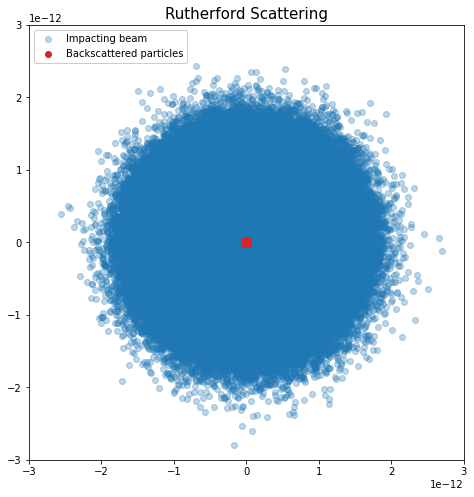

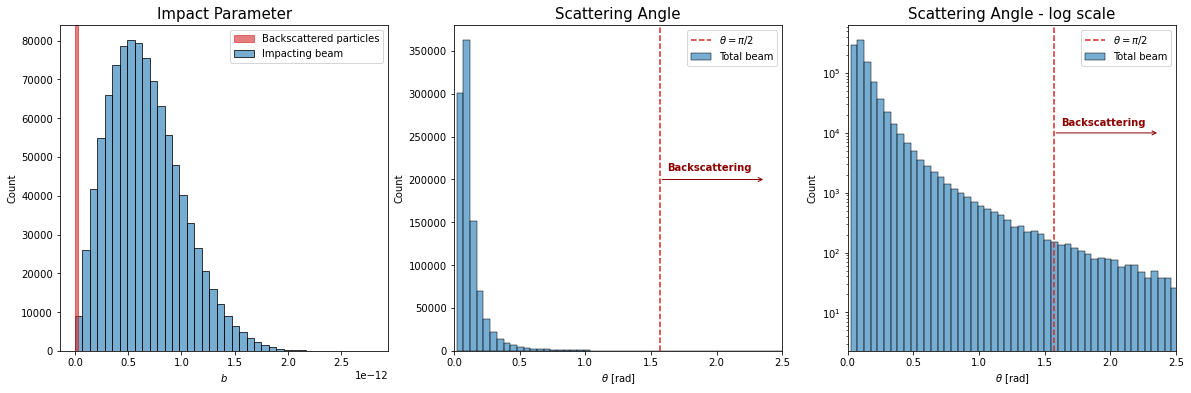

In [77]:
# PLOT
fig, ax0 = plt.subplots(1, 1, figsize=(8, 8))

# ## beam 
ax0.scatter(beam[0], beam[1], color='C0', alpha=0.3, label='Impacting beam')
ax0.scatter(beam[0][mask], beam[1][mask], color='C3', label='Backscattered particles')
ax0.set_xlim([-3e-12, 3e-12])
ax0.set_ylim([-3e-12, 3e-12])
ax0.set_aspect('equal')
ax0.set_title('Rutherford Scattering', fontsize=15)
ax0.legend(loc='upper left', framealpha=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
## impact parameter
sns.histplot(b, ax=ax1, bins=40, label='Impacting beam', alpha=0.6)
ax1.axvspan(b[mask].min(), b[mask].max(), label='Backscattered particles', color='C3', alpha=0.6)
# ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')
ax1.set_xlabel(r'$b$')
ax1.set_title('Impact Parameter', fontsize=15)
ax1.legend()

## scattering angle
sns.histplot(theta, ax=ax2, bins=60, label='Total beam', alpha=0.6)
ax2.axvline(np.pi/2, label=r'$\theta=\pi/2$', color='C3', linestyle='--')
ax2.set_xlabel(r'$\theta$ [rad]')
ax2.set_title('Scattering Angle', fontsize=15)
ax2.set_xlim([0, 2.5])
_, ymax = ax2.get_ylim()
ax2.annotate("", xy=(np.pi/2+0.8, 200000), xytext=(np.pi/2, 200000), weight='bold',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='darkred'))
ax2.text(np.pi/2+0.05, 210000, "Backscattering", color='darkred', fontweight='bold')
ax2.legend();

## scattering angle - log scale
sns.histplot(theta, ax=ax3, bins=60, label='Total beam', alpha=0.6)
ax3.axvline(np.pi/2, label=r'$\theta=\pi/2$', color='C3', linestyle='--')
ax3.set_xlabel(r'$\theta$ [rad]')
ax3.set_title('Scattering Angle - log scale', fontsize=15)
ax3.set_xlim([0, 2.5])
_, ymax = ax3.get_ylim()
ax3.annotate("", xy=(np.pi/2+0.8, 10**4), xytext=(np.pi/2, 10**4), weight='bold',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='darkred'))
ax3.text(np.pi/2+0.05, 1.3*10**4, "Backscattering", color='darkred', fontweight='bold')
ax3.set_yscale('log')
ax3.legend();

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

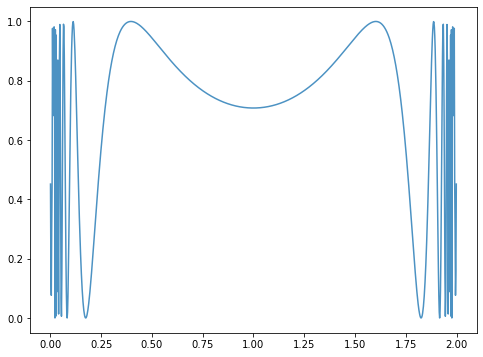

In [78]:
def f(x):
    return np.sin(1/(x*(2-x)))**2

# Plot the function
x_plot = np.linspace(0.001, 1.999, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_plot, f(x_plot), alpha=0.8);


In [79]:
N = 100000
A = 2

# HIT/MISS METHOD
# generate points in the region
x = np.random.uniform(0.0001, 1.9999, N)
y = np.random.uniform(0, 1, N)
# accept-reject criterion 
accepted = x[y < f(x)].size

I=accepted/N*A
p = accepted/N
err_I = 2*np.sqrt(N*p*(1-p))/N # binomial distribution
print('Hit/miss method: %.5f +- %.5f' %(I, err_I))

# MEAN VALUE METHOD
I_mv = 2/N*np.sum(f(x))
err_I_mv = 2*np.sqrt((np.sum(f(x)**2)/N-np.sum(f(x)/N)**2)/N)
print('Mean value method: %.5f +- %.5f' %(I_mv, err_I_mv))

Hit/miss method: 1.45752 +- 0.00281
Mean value method: 1.45593 +- 0.00165


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [80]:
# f(x, y)
def f(x, y):
    if x**2+y**2<=1: return 1 
    else: return 0
    
# compute the area analitically
print('Area of a circle of unit radius: %0.4f' %np.pi)

# Monte Carlo integration
N_points=200000
count=0
for i in range(N_points):
    # at each step create a random point (x, y, z) in the region
    x=2*np.random.random()-1    # x in [-1, 1]
    y=2*np.random.random()-1    # y in [-1, 1]
    z=1.5*np.random.random()      # z in [0, 1.5]
    
    # check if y falls under the curve 
    if z<f(x, y): count+=1
    
V = 2*2*1.5
I=V*count/N_points
print('\nThe area is the volume divided by the height, so V/1')
print('Area with MC integration: %0.5f' %I)

Area of a circle of unit radius: 3.1416

The area is the volume divided by the height, so V/1
Area with MC integration: 3.14280


For an $N$-dimensional sphere, consider 

$$
f(x_1, ... , x_n)=
\left\{
\begin{array}{ll}
      1 & \sum_{i=1}^{N} x_i^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

The $N$-dimensional integral of this sphere is $1*Vol=Vol$.

In [81]:
def f_ndim(x):
    # x is an N-dim array
    if np.sum(x**2)<=1: return 1 
    else: return 0
    
def volume_ndim_sphere(N, N_points = 1000):      
    # Monte Carlo integration (radius = 1)
    hfactor = 2 # z in [0, 2]
    # create a random points (x1, ..., xN+1) in the region
    x = 2*np.random.random((N_points, N))-1 
    z = hfactor*np.random.random(N_points)      
    
    # check if y falls under the curve 
    count = np.sum([zi <= f_ndim(xi) for zi, xi in zip(z, x)])
    V = 2**N*hfactor
    return V*count/N_points

# Some tests
print('2D sphere (circle): %0.5f --> real value: %0.5f' %(volume_ndim_sphere(2, 20000), np.pi))
print('3D sphere: %0.5f --> real value: %0.5f' %(volume_ndim_sphere(3, 100000), 4/3*np.pi))
print('10D sphere: %0.5f --> real value: %0.5f' %(volume_ndim_sphere(10, 500000), np.pi**5/120))


2D sphere (circle): 3.13520 --> real value: 3.14159
3D sphere: 4.23552 --> real value: 4.18879
10D sphere: 2.49446 --> real value: 2.55016


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [82]:
# define f(x) and w(x)
def f(x):
    return x**(-1/2)/(np.exp(x)+1)

def w(x):
    return 1/np.sqrt(x)

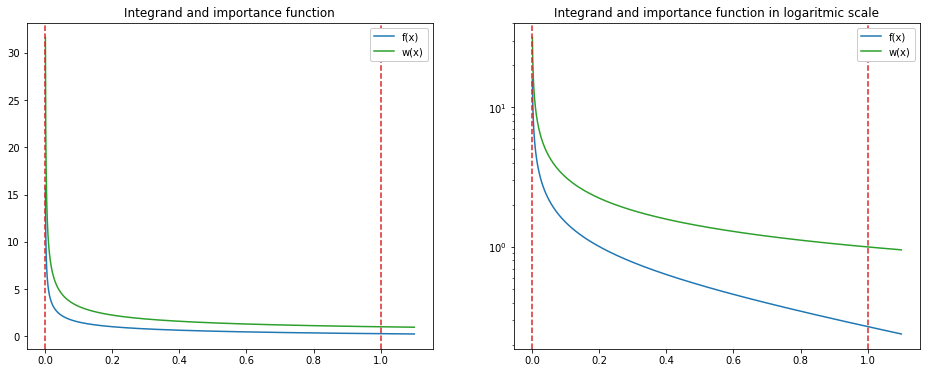

In [83]:
# plot the function 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
x = np.linspace(0.001, 1.1, 2000)
ax1.plot(x, f(x), label='f(x)', color='C0')
ax1.plot(x, w(x), label='w(x)', color='C2')
ax1.axvline(0, color='C3', linestyle='--')
ax1.axvline(1, color='C3', linestyle='--')
ax1.legend(loc='upper right', framealpha=1)
ax1.set_title('Integrand and importance function')

ax2.plot(x, f(x), label='f(x)', color='C0')
ax2.plot(x, w(x), label='w(x)', color='C2')
ax2.axvline(0, color='C3', linestyle='--')
ax2.axvline(1, color='C3', linestyle='--')
ax2.legend(loc='upper right', framealpha=1)
ax2.set_yscale('log')
ax2.set_title('Integrand and importance function in logaritmic scale');


In [84]:
# integral between 0 and 1 of w(x)
I_w = 2

# random samples between 0 and 1, from an uniform distribution
N = 1000
xsamples = np.random.random(N)

# compute the integral
I = np.sum(f(xsamples)/w(xsamples))*I_w/N
print('Value of the integral: %.5f' %I)


Value of the integral: 0.75389


The result is not so good. Let's try to increase the number of points.

In [85]:
# integral between 0 and 1 of w(x)
I_w = 2

# random samples between 0 and 1, from an uniform distribution
N = 100000
xsamples = np.random.random(N)

# compute the integral
I = np.sum(f(xsamples)/w(xsamples))*I_w/N
print('Value of the integral: %.5f' %I)

Value of the integral: 0.75937


Still the result is not is not satisfying. This is because we need a higher probability of drawing the samples close to the asymptote at $x=0$. Let's try to square the uniform distribution, so that we have a higher probability of getting smaller samples. 

Value of the integral: 0.83829


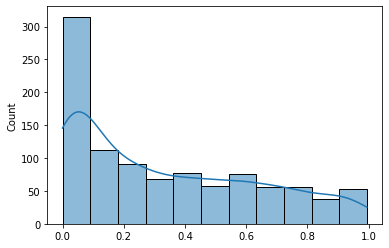

In [86]:
# integral between 0 and 1 of w(x)
I_w = 2

# random samples between 0 and 1, from an uniform distribution squared
N = 1000
xsamples = np.random.random(N)**2

# compute the integral
I = np.sum(f(xsamples)/w(xsamples))*I_w/N
print('Value of the integral: %.5f' %I)

# plot the distribution
sns.histplot(xsamples, kde=True)
plt.show()

And indeed this is a much better result. 